In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
names=open("YoloDetection/coco.names").read()
names=names.strip().split("\n")
print(names)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'orange', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [3]:
weights_path = 'YoloDetection/yolov3.weights'
configuration_path = 'YoloDetection/yolov3.cfg'

pro_min = 0.5 # Setting minimum probability to eliminate weak predictions

threshold = 0.3 # Setting threshold for non maximum suppression

Generally in a sequential CNN network there will be only one output layer at the end. In the YOLO v3 architecture we are using there are multiple output layers giving out predictions. get_output_layers() function gives the names of the output layers. An output layer is not connected to any next layer.

In [4]:
net = cv2.dnn.readNetFromDarknet(configuration_path,weights_path)

# Getting names of all layers
layers = net.getLayerNames()
output_layers=[layers[i - 1] for i in net.getUnconnectedOutLayers()] # We are searching for unconnected layers as output layers are not connected with any layer.

print(output_layers)

['yolo_82', 'yolo_94', 'yolo_106']


(480, 640, 3)


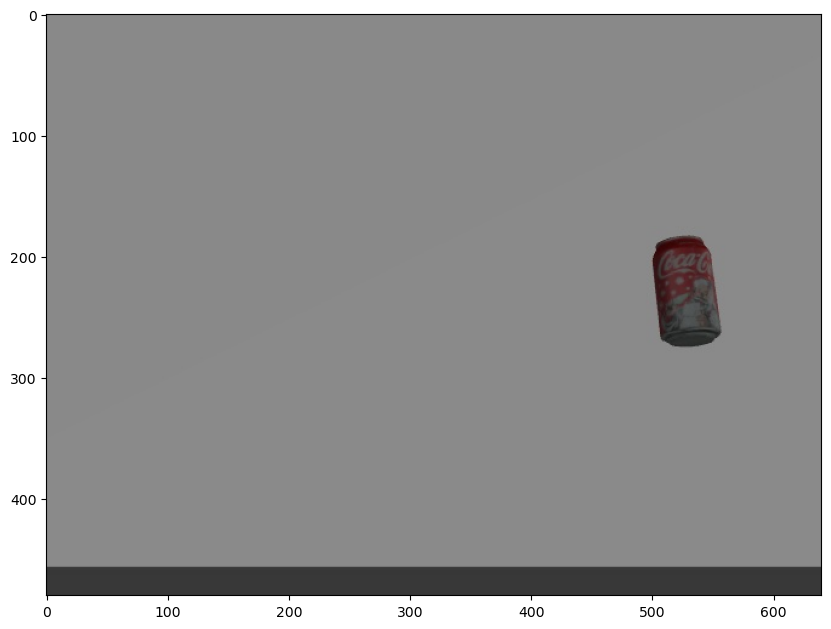

In [5]:
image = cv2.imread('Ros_Gazebo_image/frame0008.jpg')
print(image.shape)
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [7]:
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, swapRB=True, crop=False)


# Check point
print(image.shape)
print(blob.shape)

(480, 640, 3)
(1, 3, 480, 640)


(480, 640, 3)


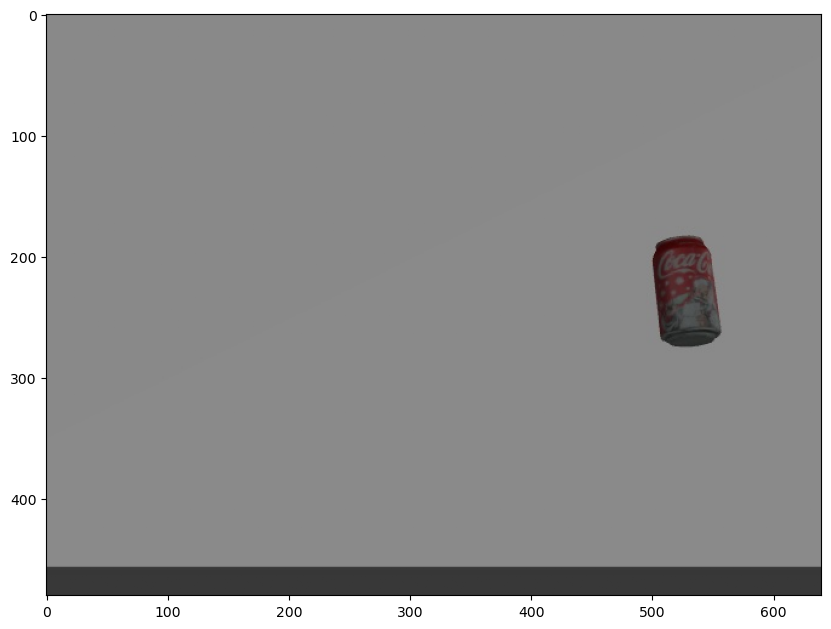

In [8]:
# Slicing blob and transposing to make channels come at the end
blob_to_show = blob[0, :, :, :].transpose(1, 2,0)
print(blob_to_show.shape)

plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(blob_to_show)
plt.show()

In [9]:
net.setInput(blob) # giving blob as input to our YOLO Network.
t1=time.time()
output = net.forward(output_layers)
t2 = time.time()

# Showing spent time for forward pass
print('YOLO took {:.5f} seconds'.format(t2-t1))

YOLO took 1.89062 seconds


In [10]:
colours = np.random.randint(0, 255, size=(len(names), 3), dtype='uint8')
classes = []
confidences = []
boxes = []
Height = image.shape[0]
Width = image.shape[1]
print(Width)

640


In [11]:
for out in output:
    for res in out:

#         print(res)
        scores = res[5:]
#         print(scores)
        class_current = np.argmax(scores) # returning indices with max score and that would be our class as that will be 1 and rest will be 0

        # Getting the probability for current object by accessing the indices returned by argmax.
        confidence_current = scores[class_current]

        # Eliminating the weak predictions that is with minimum probability and this loop will only be encountered when an object will be there
        if confidence_current > 0.5:

            # Scaling bounding box coordinates to the initial image size
            # YOLO data format just keeps center of detected box and its width and height
            #that is why we are multiplying them elemwnt wise by width and height
            box = res[0:4] * np.array([Width, Height, Width, Height])  #In the first 4 indices only contains
            #the output consisting of the coordinates.
            print(res[0:4])
            print(box)

            # From current box with YOLO format getting top left corner coordinates
            # that are x and y
            x, y, w, h = box.astype('int')
            x = int(x - (w / 2))
            y = int(y - (h / 2))


            # Adding results into the lists
            boxes.append([x, y, int(w), int(h)]) ## appending all the boxes.
            confidences.append(float(confidence_current)) ## appending all the confidences
            classes.append(class_current) ## appending all the classes

In [12]:
results = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,0.4) # -> indices the kept indices of bboxes after NMS.

# Showing labels of the detected objects
for i in range(len(classes)):
    print(names[int(classes[i])])

In [13]:
len(results)

0

In [14]:
if len(results) > 0:

    for i in results.flatten():

        # Getting current bounding box coordinates
        x, y = boxes[i][0],boxes[i][1]
        width, height = boxes[i][2], boxes[i][3]

        colour_box_current = [int(j) for j in colours[classes[i]]]

        # Drawing bounding box on the original image
        cv2.rectangle(image, (x, y), (x + width, y + height),
                      colour_box_current, 2)

        # Preparing text with label and confidence
        text_box_current = '{}: {:.4f}'.format(names[int(classes[i])], confidences[i])

        # Putting text with label and confidence
        cv2.putText(image, text_box_current, (x+2, y+20), cv2.FONT_HERSHEY_DUPLEX, 0.5,(0,0,0))

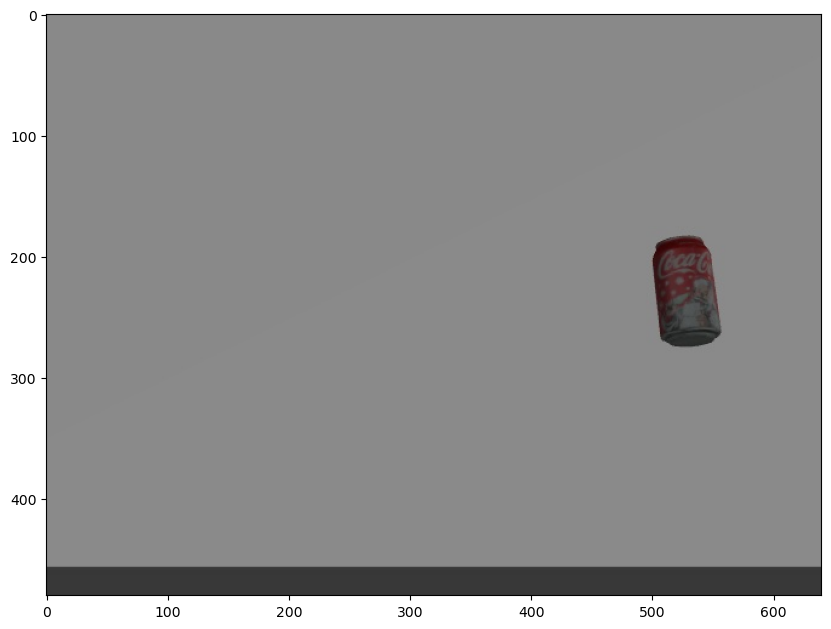

In [15]:
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
ix = results[0]

In [23]:
for ix in results.flatten():
    print(names[int(classes[ix])])

banana


In [17]:
width, height = boxes[ix][2], boxes[ix][3]
width

68

In [18]:
height

127

In [18]:
from grasp_model import MPA_SegmentationNetwork
import torch
from dataset_processing.grasp import detect_grasps,GraspRectangles
from dataset_processing import grasp, image
from Training import post_process_output
from imageio import imread
from skimage.feature import peak_local_max
from skimage.filters import gaussian
import torch
model = torch.load('Weights/grasp_model.pth',map_location=torch.device('cpu'))

In [28]:

from torchvision import transforms
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rgb_img = image.Image.from_file('Ros_Gazebo_image/frame0002.jpg')
#rgb_img = imread('dataset/08/pcd0856r.png')
'''
input = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)
input = input.type(torch.float)
input = input.to(device)
pos_pred, cos_pred, sin_pred, width_pred = model(input)
q_out, ang_out, w_out = post_process_output(pos_pred, cos_pred,sin_pred,width_pred)
gs_1 = detect_grasps(q_out, ang_out, width_img=w_out, no_grasps=1)
gs_1
'''
rgb_img.normalise()
rgb_img.img = rgb_img.img.transpose((2, 0, 1))

x = torch.from_numpy(np.expand_dims(rgb_img.img, 0).astype(np.float32))
pos_pred, cos_pred, sin_pred, width_pred = model(x)

In [29]:
ang_img = (torch.atan2(sin_pred, cos_pred) / 2.0).data.detach().cpu().numpy().squeeze()
q_img = pos_pred.data.detach().cpu().numpy().squeeze()
q_img.shape

(480, 640)

In [12]:
from skimage.feature import peak_local_max
from skimage.filters import gaussian

local_max = peak_local_max(q_img, min_distance=20, num_peaks=1)
local_max

array([[314, 533]], dtype=int64)

In [19]:
def post_process_output(q_img, cos_img, sin_img, width_img):
    """
    Post-process the raw output of the GG-CNN, convert to numpy arrays, apply filtering.
    :param q_img: Q output of GG-CNN (as torch Tensors)
    :param cos_img: cos output of GG-CNN
    :param sin_img: sin output of GG-CNN
    :param width_img: Width output of GG-CNN
    :return: Filtered Q output, Filtered Angle output, Filtered Width output
    """
    q_img = q_img.data.detach().cpu().numpy().squeeze()
    ang_img = (torch.atan2(sin_img, cos_img) / 2.0).data.detach().cpu().numpy().squeeze()
    width_img = width_img.data.detach().cpu().numpy().squeeze() * 150.0

    q_img = gaussian(q_img, 2.0, preserve_range=True)
    ang_img = gaussian(ang_img, 2.0, preserve_range=True)
    width_img = gaussian(width_img, 1.0, preserve_range=True)

    return q_img, ang_img, width_img

In [31]:
q_out, ang_out, w_out = post_process_output(pos_pred, cos_pred, sin_pred, width_pred)
gs_1 = detect_grasps(q_out, ang_out, width_img=w_out, no_grasps=1)
gs_1

In [20]:
def get_rgb_file(filepath, normalise=True):
    rgb_img = image.Image.from_file(filepath)

    if normalise:
        rgb_img.normalise()
        rgb_img.img = rgb_img.img.transpose((2, 0, 1))
    return rgb_img.img

In [24]:
fig = plt.figure(figsize=(20, 10))

immage = (get_rgb_file('dataset/08/pcd0856r.png',normalise=False))
ax = fig.add_subplot(1,1,1)
ax.imshow(immage)
ax.axis('off')
for g in gs_1:
    g.plot(ax)
plt.show(block=False)

In [32]:

rgb_img = image.Image.from_file('Ros_Gazebo_image/frame0010.jpg')
#rgb_img = imread('dataset/08/pcd0856r.png')
'''
input = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)
input = input.type(torch.float)
input = input.to(device)
pos_pred, cos_pred, sin_pred, width_pred = model(input)
q_out, ang_out, w_out = post_process_output(pos_pred, cos_pred,sin_pred,width_pred)
gs_1 = detect_grasps(q_out, ang_out, width_img=w_out, no_grasps=1)
gs_1
'''
rgb_img.normalise()
rgb_img.img = rgb_img.img.transpose((2, 0, 1))

x = torch.from_numpy(np.expand_dims(rgb_img.img, 0).astype(np.float32))
pos_pred, cos_pred, sin_pred, width_pred = model(x)
q_out, ang_out, w_out = post_process_output(pos_pred, cos_pred, sin_pred, width_pred)
gs_1 = detect_grasps(q_out, ang_out, width_img=w_out, no_grasps=3)
gs_1[0].center

(119, 453)

In [33]:
from dataset_processing.grasp import Grasp

fig = plt.figure(figsize=(20, 10))

immage = (get_rgb_file('Ros_Gazebo_image/frame0010.jpg',normalise=False))
ax = fig.add_subplot(1,1,1)
ax.imshow(immage)
ax.axis('off')
for g in gs_1:
    cy = (g.center[0]+(abs((127/2)-g.center[0]))) / 2
    #cy = (g.center[0] + 127/2) / 2
    cx = g.center[1]
    gr = Grasp((cy,cx),angle=g.angle,length=g.length,width=g.width)

    #g.center[0] = (g.center[0] + 127) / 2
    g.plot(ax)
plt.show(block=False)

In [16]:
image = cv2.imread("Ros_Gazebo_image/frame0010.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
thresh[0:50,:] = 0
thresh[430:,:] = 0


# Find bounding box
x,y,w,h = cv2.boundingRect(thresh)
cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
cv2.putText(image, "w={},h={}".format(w,h), (x,y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (36,255,12), 2)

cv2.imshow("thresh", thresh)
cv2.imshow("image", image)
cv2.waitKey()


-1

In [6]:
color = (255, 255, 255)
for g in gs_1:
    xo = np.cos(g.angle)
    yo = np.sin(g.angle)

    y1 = g.center[0] + g.length / 2 * yo
    x1 = g.center[1] - g.length / 2 * xo
    y2 = g.center[0] - g.length / 2 * yo
    x2 = g.center[1] + g.length / 2 * xo



width: 66
